In [445]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score,classification_report
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# Set random seed
rs = 42
# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

## Load

In [252]:
train=pd.read_csv('train.csv')
original=pd.read_csv('final_depression_dataset_1.csv')
test=pd.read_csv('test.csv')

In [253]:
test.isnull().sum()/test.shape[0]
#test.info()

id                                       0.000000
Name                                     0.000000
Gender                                   0.000000
Age                                      0.000000
City                                     0.000000
Working Professional or Student          0.000000
Profession                               0.262601
Academic Pressure                        0.799925
Work Pressure                            0.200192
CGPA                                     0.799936
Study Satisfaction                       0.799925
Job Satisfaction                         0.200149
Sleep Duration                           0.000000
Dietary Habits                           0.000053
Degree                                   0.000021
Have you ever had suicidal thoughts ?    0.000000
Work/Study Hours                         0.000000
Financial Stress                         0.000000
Family History of Mental Illness         0.000000
dtype: float64

In [254]:
original.head(2)
# original is missing id column and test is missing depression column
train.shape,original.shape, test.shape

((140700, 20), (2556, 19), (93800, 19))

In [255]:
#train.head(5)

In [256]:
original['Depression'] = original['Depression'].map({"Yes": 1, "No": 0})
combo = pd.concat([train, original], ignore_index=True)

## Clean and Explore

In [9]:
#df.drop(columns=['id', 'Name'], inplace=True)


In [10]:
df.isnull().sum()

id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

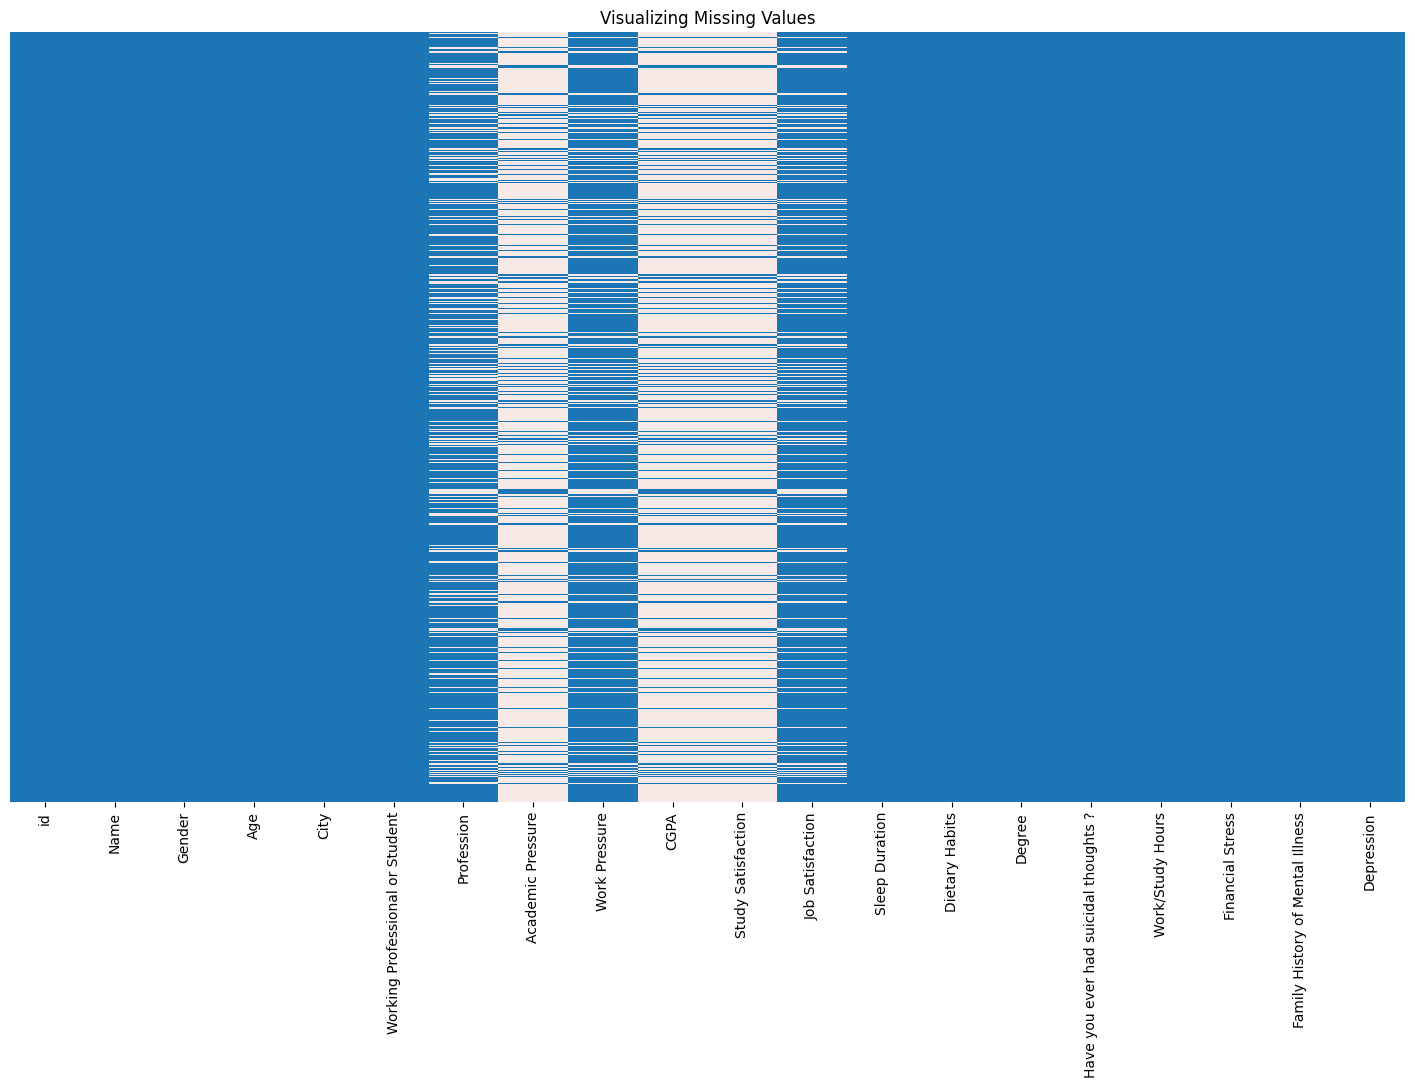

In [11]:
plt.figure(figsize=(18,10))
plt.title("Visualizing Missing Values")
sns.heatmap(df.isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

In [12]:
df.isnull().sum()/df.shape[0]*100

id                                        0.000000
Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                     

In [13]:
df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()


In [195]:
# get categorical columns
cat_cols=df.columns[df.dtypes=='O'].to_list()
# get numerical columns
num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']


In [197]:
len(cat_cols) , len(num_cols)
num_cols

['age',
 'academic-pressure',
 'work-pressure',
 'cgpa',
 'study-satisfaction',
 'job-satisfaction',
 'work/study-hours',
 'financial-stress']

In [16]:
cat_cols

['name',
 'gender',
 'city',
 'working-professional-or-student',
 'profession',
 'sleep-duration',
 'dietary-habits',
 'degree',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']

In [17]:
# Convert the content of all colums to lower case
for col in cat_cols:
    df[col]=df[col].str.lower()


In [18]:
#df.isnull().sum()

## Handling missing value in categorical columns  
Classifying all the values having a value count of less than 100 to a different new class noise and fill the NaN values to new class missing.

In [19]:
threshold=100
for col in df.select_dtypes('object').columns:
    # fill in all NaN by 'missing'
    df[col] = df[col].fillna('missing')
    # computes the frequency of each unique value in the column, including NaN values
    # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
    df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"

In [20]:
for col in num_cols:
        df[col]=df[col].fillna(0)

In [21]:
#df.isnull().sum()

In [22]:
#df.isnull().sum()/df.shape[0]*100

In [322]:
mean[0]

IndexError: invalid index to scalar variable.

In [319]:
mean=df['academic-pressure'].mean()
print(mode)
df.profession=df.profession.fillna(mode.iloc[0])

0    teacher
Name: profession, dtype: object


In [318]:
df['academic-pressure'].value_counts(dropna=False)

academic-pressure
3.0    120266
5.0      6296
4.0      5158
1.0      4801
2.0      4179
Name: count, dtype: int64

In [326]:
def preprocess(df, missing_num=0, missing_cat=0):
    df=df.copy()
     # Change columns titles to lower case
    df.columns=df.columns.str.lower().str.replace(' ', '-').to_list()
    # get numerical columns
    num_cols = [cols for cols in df.select_dtypes('number').columns if cols!= 'id' and cols!='depression']
   
    # get categorical columns
    cat_cols=df.columns[df.dtypes=='O'].to_list()
    # Change categorical column content to lower case
    for col in cat_cols:
        df[col]=df[col].str.lower()
    if missing_cat=='Mode':
        for col in cat_cols:
            # fill in all NaN by the mode
            mode=df[col].mode()
            df[col] = df[col].fillna(mode.iloc[0])
    elif missing_cat==0:
        threshold=100
        for col in cat_cols:
            # fill in all NaN by 'missing'
            df[col] = df[col].fillna('missing')
            # computes the frequency of each unique value in the column, including NaN values
            # sets the value of the column to "noise" for all rows where the boolean condition (value count is less than threshold) is true.
            df.loc[df[col].value_counts(dropna=False)[df[col]].values < threshold, col] = "noise"
    else:
        print('Enter the correct value for missing_cat')
    if missing_num=='Mean': 
        for col in num_cols:
            mean=df[col].mean()
            df[col]=df[col].fillna(mean)
    elif missing_num=='Median':
        for col in num_cols:
            median=df[col].median()
            df[col]=df[col].fillna(median)
    elif missing_num==0:
         for col in num_cols:
            df[col]=df[col].fillna(0)
    else:
        print('Enter the correct value for missing_num')
    # remove name column as it does not affect the target
    cat_cols.remove('name')
    features=num_cols+cat_cols
    
    
    

    return features, df

  
    
    

In [327]:
features, df=preprocess(train,0, 'Mode')
len(features) , df.shape
df['academic-pressure'].value_counts(), df['profession'].value_counts()

(academic-pressure
 0.0    112803
 3.0      7463
 5.0      6296
 4.0      5158
 1.0      4801
 2.0      4179
 Name: count, dtype: int64,
 profession
 teacher           61536
 content writer     7814
 architect          4370
 consultant         4229
 hr manager         4022
                   ...  
 bba                   1
 city manager          1
 familyvirar           1
 b.com                 1
 yuvraj                1
 Name: count, Length: 64, dtype: int64)

## Base Model

In [40]:
df.depression.value_counts(normalize=True)  # base accuracy is 82%


depression
0    0.818287
1    0.181713
Name: proportion, dtype: float64

## Split

In [41]:
from sklearn.model_selection import train_test_split

In [133]:
def split_data(df):
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
    # reset index 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # get the target values
    y_train = df_train.depression.values
    y_val = df_val.depression.values
    y_test=df_test.depression.values
    # drop target
    del df_train['depression']
    del df_val['depression']
    del df_test['depression']
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict=df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    test_dict=df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    print( df_train.shape,df_val.shape, df_test.shape)
    return df_train , X_train, y_train, X_val, y_val, X_test, y_test

In [130]:
X_train, y_train, X_val, y_val, X_test, y_test =split_data(df)

## Exploratory data analysis

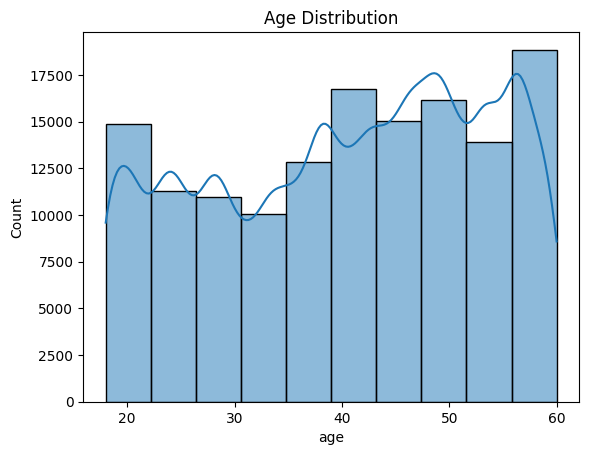

In [48]:
sns.histplot(data=df, x='age', bins=10, kde=True)
plt.title("Age Distribution")
plt.show()

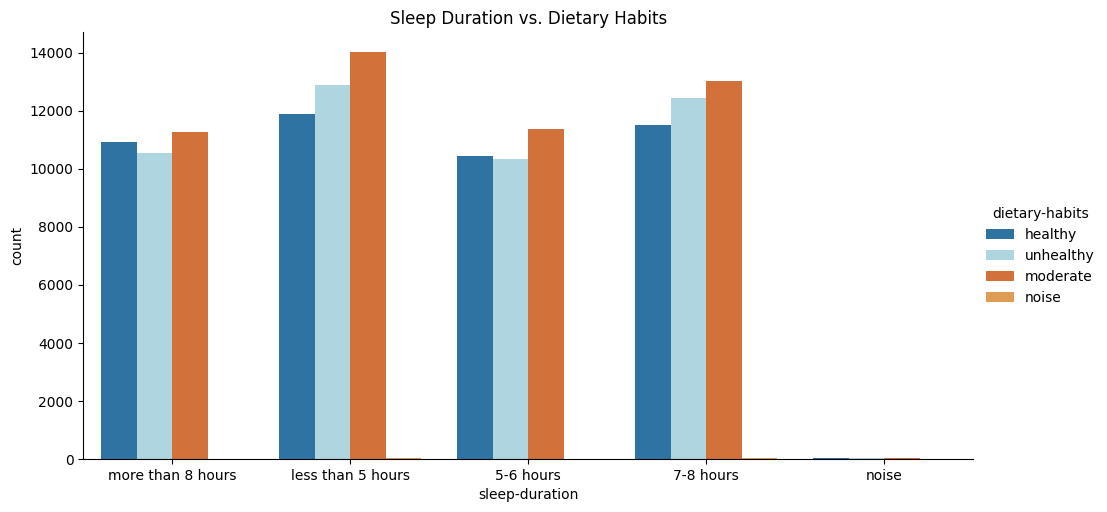

In [49]:
sns.catplot(data=df, x='sleep-duration', hue='dietary-habits', kind='count', height=5, aspect=2)
plt.title("Sleep Duration vs. Dietary Habits")
plt.show()


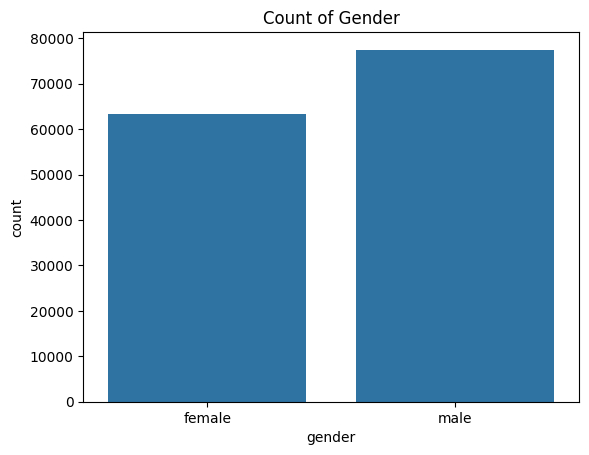

In [50]:
sns.countplot(data=df, x='gender')
plt.title("Count of Gender")
plt.show()


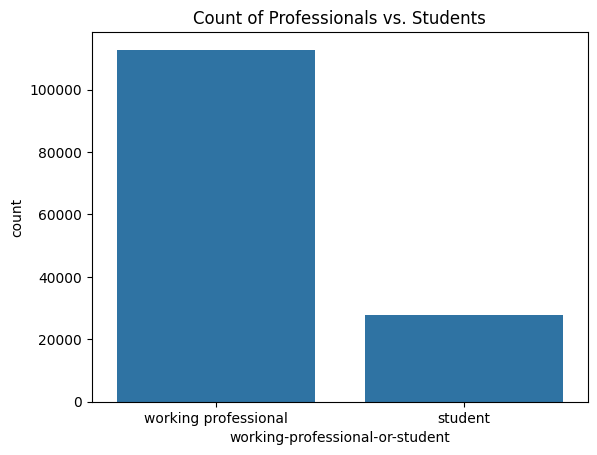

In [51]:
sns.countplot(data=df, x='working-professional-or-student')
plt.title("Count of Professionals vs. Students")
plt.show()


In [52]:
df_train_full.depression.value_counts(normalize=True)

depression
0    0.817884
1    0.182116
Name: proportion, dtype: float64

In [53]:
global_mean = df_train_full.depression.mean()
round(global_mean, 3)

0.182

In [54]:
df_train_full[cat_cols].nunique()

name                                     209
gender                                     2
city                                      31
working-professional-or-student            2
profession                                37
sleep-duration                             5
dietary-habits                             4
degree                                    28
have-you-ever-had-suicidal-thoughts-?      2
family-history-of-mental-illness           2
dtype: int64

In [55]:
female_mean = df_train_full[df_train_full.gender == 'female'].depression.mean()
print('gender == female:', round(female_mean, 3))

male_mean = df_train_full[df_train_full.gender == 'male'].depression.mean()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.179
gender == male:   0.184


In [56]:
female_mean / global_mean

0.985333280875737

In [57]:
male_mean / global_mean

1.0119970280230686

In [58]:
df_group = df_train_full.groupby(by='gender').depression.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean
df_group

,mean,diff,risk
gender,,,
female,0.179445,-0.002671,0.985333
male,0.184301,0.002185,1.011997


In [59]:
from IPython.display import display

In [60]:
global_mean = df_train_full.depression.mean()
global_mean

0.18211620469083156

In [61]:
for col in cat_cols:
    df_group = df_train_full.groupby(by=col).depression.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
name,,,
aadhya,0.206070,0.023954,1.131532
aahana,0.220557,0.038441,1.211077
aakash,0.224490,0.042374,1.232673
aanchal,0.196691,0.014575,1.080031
aaradhya,0.195561,0.013445,1.073825
...,...,...,...
yashvi,0.149837,-0.032279,0.822756
yogesh,0.309434,0.127318,1.699102
yuvraj,0.166667,-0.015450,0.915167


,mean,diff,risk
gender,,,
female,0.179445,-0.002671,0.985333
male,0.184301,0.002185,1.011997


,mean,diff,risk
city,,,
agra,0.195083,0.012967,1.071200
ahmedabad,0.218030,0.035914,1.197202
bangalore,0.172903,-0.009213,0.949409
bhopal,0.238628,0.056512,1.310307
chennai,0.191841,0.009724,1.053396
delhi,0.188022,0.005906,1.032430
faridabad,0.145143,-0.036973,0.796979
ghaziabad,0.197859,0.015743,1.086444
hyderabad,0.281145,0.099029,1.543766


,mean,diff,risk
working-professional-or-student,,,
student,0.585200,0.403084,3.213335
working professional,0.081938,-0.100179,0.449919


,mean,diff,risk
profession,,,
accountant,0.068966,-0.113151,0.378690
architect,0.098271,-0.083845,0.539605
business analyst,0.056949,-0.125167,0.312709
chef,0.047826,-0.134290,0.262613
chemist,0.027197,-0.154920,0.149337
civil engineer,0.075130,-0.106987,0.412536
consultant,0.046810,-0.135306,0.257032
content writer,0.018944,-0.163173,0.104020
customer support,0.046341,-0.135775,0.254461


,mean,diff,risk
sleep-duration,,,
5-6 hours,0.165000,-0.017117,0.906013
7-8 hours,0.179899,-0.002217,0.987826
less than 5 hours,0.234377,0.052261,1.286964
more than 8 hours,0.139668,-0.042448,0.766919
noise,0.142857,-0.039259,0.784429


,mean,diff,risk
dietary-habits,,,
healthy,0.118268,-0.063848,0.649412
moderate,0.166231,-0.015886,0.912772
noise,0.450000,0.267884,2.470950
unhealthy,0.261135,0.079018,1.433890


,mean,diff,risk
degree,,,
b.arch,0.157524,-0.024592,0.864966
b.com,0.155658,-0.026458,0.854719
b.ed,0.129940,-0.052176,0.713500
b.pharm,0.117672,-0.064444,0.646137
b.tech,0.213217,0.031100,1.170772
ba,0.124664,-0.057452,0.684530
bba,0.135411,-0.046705,0.743544
bca,0.207092,0.024975,1.137140
be,0.187500,0.005384,1.029562


,mean,diff,risk
have-you-ever-had-suicidal-thoughts-?,,,
no,0.049038,-0.133079,0.269266
yes,0.318135,0.136019,1.746881


,mean,diff,risk
family-history-of-mental-illness,,,
no,0.175338,-0.006778,0.962783
yes,0.188967,0.006851,1.037618


In [62]:
from sklearn.metrics import mutual_info_score

In [63]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.depression)

df_mi = df_train_full[cat_cols].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
    
    
display(df_mi.head())
display(df_mi.tail())

,MI
profession,0.135946
working-professional-or-student,0.112467
have-you-ever-had-suicidal-thoughts-?,0.066372
degree,0.038233
name,0.015593


,MI
dietary-habits,0.011435
sleep-duration,0.004113
city,0.003955
family-history-of-mental-illness,0.000156
gender,0.000020


## Train

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
import time

In [96]:
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
dv = DictVectorizer(sparse=False)


In [97]:
len(df_train.columns)
#df_train.head()

19

In [98]:
train_dict=df_train[features].to_dict(orient='records')
print(train_dict[0])
X_train = dv.fit_transform(train_dict)

lr.fit(X_train, y_train)

{'age': 47.0, 'academic-pressure': 0.0, 'work-pressure': 4.0, 'cgpa': 0.0, 'study-satisfaction': 0.0, 'job-satisfaction': 1.0, 'work/study-hours': 12.0, 'financial-stress': 5.0, 'gender': 'male', 'city': 'kolkata', 'working-professional-or-student': 'working professional', 'profession': 'teacher', 'sleep-duration': '7-8 hours', 'dietary-habits': 'unhealthy', 'degree': 'llb', 'have-you-ever-had-suicidal-thoughts-?': 'yes', 'family-history-of-mental-illness': 'no'}


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [99]:
## Tree models
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)

In [100]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- age <= 33.50
|   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |--- academic-pressure <= 3.50
|   |   |   |--- class: 0
|   |   |--- academic-pressure >  3.50
|   |   |   |--- class: 1
|   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |--- academic-pressure <= 2.50
|   |   |   |--- class: 1
|   |   |--- academic-pressure >  2.50
|   |   |   |--- class: 1
|--- age >  33.50
|   |--- academic-pressure <= 2.50
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |   |--- class: 0
|   |--- academic-pressure >  2.50
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- have-you-ever-had-suicidal-thoughts-?=yes >  0.50
|   |   |   |--- class: 1



In [101]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=lr.predict(X_val)

In [102]:
accuracy_score(y_val, y_pred)

0.9409737029140014

In [103]:
import time

In [155]:
def train_data(df, model):
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model.fit(X_train, y_train)


    return model

In [105]:
t=time.time()
t

1731347191.7679482

In [106]:
t0=time.time()
LR=train(df_train, lr)
t1=time.time()
print(t1-t0)

6.4772186279296875


## Evaluate

In [107]:
def predict(X,model):
    y_pred=model.predict(X)
    return y_pred

In [108]:
val_dict=df_val[features].to_dict(orient='records')
X_val=dv.transform(val_dict)
y_pred=predict(X_val, LR)
accuracy_score(y_val, y_pred)

0.9409737029140014

In [283]:
#df_train.academic-pressure.value_counts()

In [450]:
# try various parameters
features, df=preprocess(train)
len(features)
df_train, X_train, y_train, X_val, y_val, X_test, y_test =split_data(df)


(84420, 19) (28140, 19) (28140, 19)


In [451]:
# l2 is better  for Auc without imputation,  for Auc l1 is better with combo and for recall train only with l1 and l2 same
# with imputing mode for cat  not good for accuracy but no effect on auc and p and c

In [452]:
#df_train.profession.value_counts(dropna=False), df_train['academic-pressure'].value_counts()
#df['academic-pressure'].value_counts()

## Model fine tuning

In [453]:
from tqdm import tqdm

scores=[]
c_list=[0.045,0.05, 0.06, 0.07, 0.08,0.09,0.1,0.12, 0.2,0.3, 0.4, 0.5]
for l in ['l1','l2']:
    for c in tqdm(c_list):
        lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
        lr.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        accuracy=accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        y_predp = lr.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_predp)
        scores.append((l, c, accuracy, precision, recall, auc))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


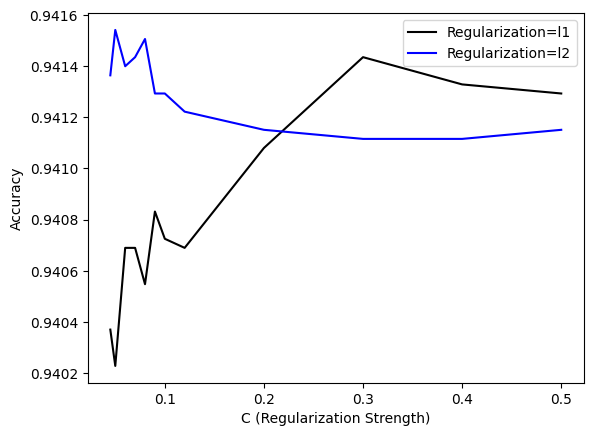

In [454]:
df_scores = pd.DataFrame(scores, columns=['L','C', 'accuracy', 'precision', 'recall', 'auc'])
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.accuracy,
             color=col,
             label='Regularization=%s' % l)
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Train only ')
plt.show()

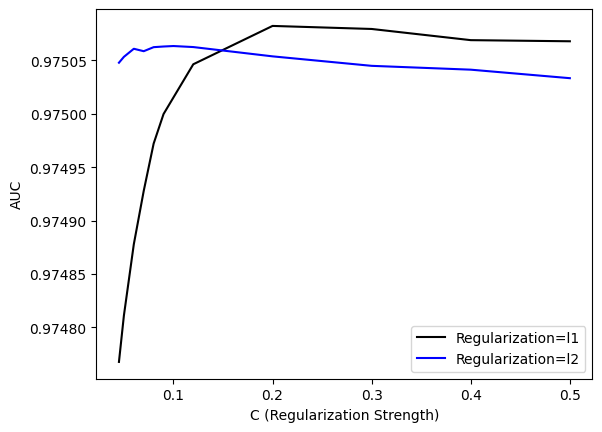

In [455]:
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.auc,
             color=col,
             label='Regularization=%s' % l)
   
plt.xlabel('C (Regularization Strength)')
plt.ylabel('AUC')
plt.legend()
plt.savefig('LR train  ')
plt.show()

In [456]:
colors = ['black', 'blue', 'green', 'orange']
l_values = ['l1', 'l1', 'l2', 'l2']
metrics = ['precision', 'recall']

# Plot each metric with a different color
for i, (l, metric) in enumerate(zip(l_values * 2, metrics * 2)):
    print(i, (l, metric))

0 ('l1', 'precision')
1 ('l1', 'recall')
2 ('l2', 'precision')
3 ('l2', 'recall')


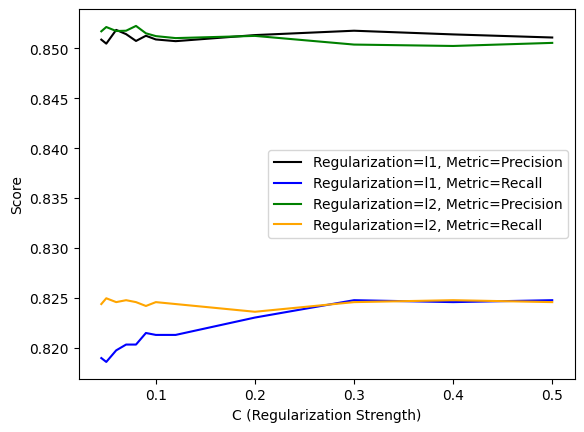

In [457]:
# Define more colors to differentiate each line
colors = ['black', 'blue', 'green', 'orange']
l_values = ['l1', 'l1', 'l2', 'l2']
metrics = ['precision', 'recall']

# Plot each metric with a different color
for i, (l, metric) in enumerate(zip(l_values , metrics * 2)):
    df_subset = df_scores[df_scores.L == l]
    
    # Plot precision and recall with different colors
    plt.plot(df_subset.C, df_subset[metric],
             color=colors[i],
             label=f'Regularization={l}, Metric={metric.capitalize()}')
    
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Score')
plt.legend()
plt.savefig('LR_train no impute')
plt.show()

[[22230   740]
 [  905  4265]]


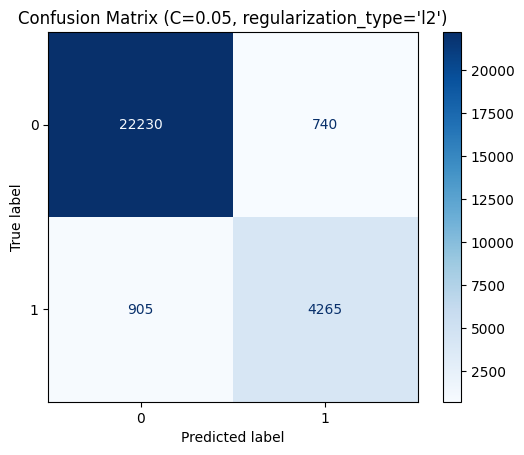

In [458]:
l='l2'
c=0.05
lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
lr.fit(X_train, y_train)
y_pred=lr.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print(cm)  # Print the raw confusion matrix

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (C={c}, regularization_type='{l}')")
plt.show()

In [459]:
print(classification_report(y_val, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22970
           1       0.85      0.82      0.84      5170

    accuracy                           0.94     28140
   macro avg       0.91      0.90      0.90     28140
weighted avg       0.94      0.94      0.94     28140



### Fine tuning with tree models

In [461]:
# try various parameters
features, df=preprocess(train)
len(features)
df_train, X_train, y_train, X_val, y_val, X_test, y_test =split_data(df)

(84420, 19) (28140, 19) (28140, 19)


In [460]:
from tqdm import tqdm
scores = []

for n in tqdm(range(1,20, 2)):
    dt = DecisionTreeClassifier(max_depth=n, random_state=1)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_val)
    y_predp = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


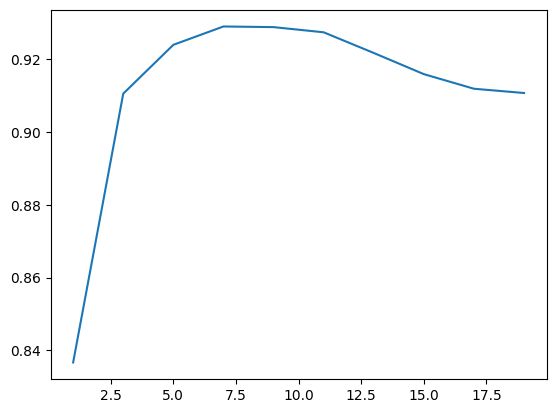

In [462]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [466]:
from tqdm import tqdm
scores = []
t0=time.time()
for n in tqdm(range(90,201, 10)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred=rf.predict(X_val)
    y_predp = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_predp)
    accuracy=accuracy=accuracy_score(y_val, y_pred)
    
    scores.append((n, auc, accuracy))
t1=time.time()
print(t1-t0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [11:34<00:00, 57.91s/it]

694.871259689331


In [467]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc', 'accuracy'])

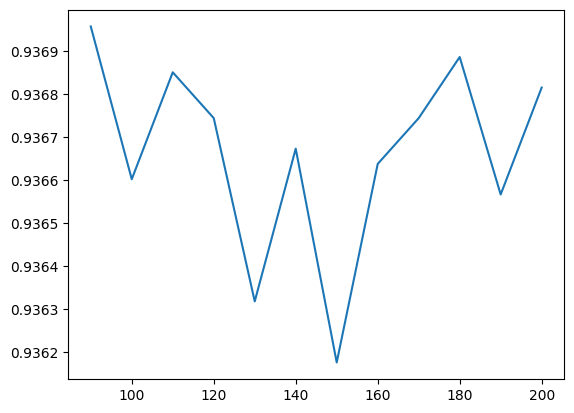

In [468]:
plt.plot(df_scores.n_estimators, df_scores.accuracy) # top auc at estimator 160 to 180

In [332]:
scores = []

for d in [5, 10, 15]:
    for n in range(150, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred=lr.predict(X_val)
        y_predp = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_predp)
        accuracy=accuracy=accuracy_score(y_val, y_pred)
        scores.append((d, n, auc, accuracy))

In [ ]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc', 'accuracy'])
plt.plot(df_scores.max_depth, df_scores.accuracy) # top auc at estimator 160 to 180

In [ ]:
test_dict=df_test[features].to_dict(orient='records')
X_test=dv.transform(test_dict)
y_pred=predict(X_test, LR)
accuracy_score(y_test, y_pred)

### Model Interpretation

In [190]:
lr.coef_[0].shape

(121,)

In [191]:
len(dv.get_feature_names())

AttributeError: 'DictVectorizer' object has no attribute 'get_feature_names'

In [206]:
dict(zip(dv.get_feature_names_out(), lr.coef_[0].round(3)))

{'academic-pressure': np.float64(0.852),
 'age': np.float64(-0.167),
 'cgpa': np.float64(0.07),
 'city=agra': np.float64(-0.176),
 'city=ahmedabad': np.float64(0.329),
 'city=bangalore': np.float64(-0.01),
 'city=bhopal': np.float64(0.029),
 'city=chennai': np.float64(-0.179),
 'city=delhi': np.float64(0.051),
 'city=faridabad': np.float64(-0.015),
 'city=ghaziabad': np.float64(0.157),
 'city=hyderabad': np.float64(0.285),
 'city=indore': np.float64(0.089),
 'city=jaipur': np.float64(-0.133),
 'city=kalyan': np.float64(0.083),
 'city=kanpur': np.float64(-0.117),
 'city=kolkata': np.float64(0.039),
 'city=lucknow': np.float64(0.017),
 'city=ludhiana': np.float64(-0.031),
 'city=meerut': np.float64(-0.096),
 'city=mumbai': np.float64(-0.371),
 'city=nagpur': np.float64(-0.279),
 'city=nashik': np.float64(0.09),
 'city=noise': np.float64(-0.249),
 'city=patna': np.float64(0.15),
 'city=pune': np.float64(-0.056),
 'city=rajkot': np.float64(0.026),
 'city=srinagar': np.float64(-0.044),
 'ci

## Submit

In [192]:
len(test)

93800

In [193]:
features,df_test_submit= preprocess(test)
df_test_submit.shape, len(features)

((93800, 19), 17)

In [703]:
df_test_submit.isnull().sum()

id                                       0
name                                     0
gender                                   0
age                                      0
city                                     0
working-professional-or-student          0
profession                               0
academic-pressure                        0
work-pressure                            0
cgpa                                     0
study-satisfaction                       0
job-satisfaction                         0
sleep-duration                           0
dietary-habits                           0
degree                                   0
have-you-ever-had-suicidal-thoughts-?    0
work/study-hours                         0
financial-stress                         0
family-history-of-mental-illness         0
dtype: int64

In [308]:
lr=LogisticRegression(solver='liblinear', C=0.05, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.05, max_iter=1000, random_state=42, solver='liblinear')

In [309]:
test_submit_dict=df_test_submit[features].to_dict(orient='records')
X_test_submit=dv.transform(test_submit_dict)
y_pred=predict(X_test_submit, LR)
y_pred[:5]

array([0, 0, 0, 1, 0])

In [310]:
submission=pd.read_csv('sample_submission.csv')

In [311]:
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,0
4,140704,0


In [312]:
submission['Depression']=y_pred

In [313]:
submission.head(10)

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
5,140705,0
6,140706,0
7,140707,0
8,140708,0
9,140709,1


In [314]:
submission.Depression.value_counts(normalize=True)

Depression
0    0.824936
1    0.175064
Name: proportion, dtype: float64

In [315]:
submission.to_csv('sub3.csv', index=False)